In [55]:
from utils.analyse_runs import *
from utils.analyse_training import *

%load_ext autoreload
%autoreload 2

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dtype=torch.float64

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# DF of all runs sorted by best_avg_loss

In [56]:
df = load_runs_table("./runs")
df.head()

,run_id,best_avg_loss,best_epoch,epoch,lr_drops_used,kernel_mode,kernel_spec,esn_h,esn_m,esn_out_dim,...,target_T,target_p,target_q,target_phi,target_theta,target_omega,target_alpha,target_beta,target_noise_spec,run_path
0,esn_vs_ARMA_RBFKernel_20260224_093047_cpu,-0.002045,254,504,3,static,RBFKernel(sigma=26.735400176591458),500,20,1,...,200.0,2.0,0.0,"[0.699999988079071, -0.20000000298023224]",[],None,None,None,"{'kind': 'normal', 'params': {}}",runs/esn_vs_ARMA_RBFKernel_20260224_093047_cpu
1,esn_vs_ARMA_RBFKernel_20260224_095230_cpu,-0.001942,247,497,3,static,RBFKernel(sigma=27.59954485390008),500,20,1,...,200.0,2.0,0.0,"[0.699999988079071, -0.20000000298023224]",[],None,None,None,"{'kind': 'normal', 'params': {}}",runs/esn_vs_ARMA_RBFKernel_20260224_095230_cpu
2,esn_vs_ARMA_RBFKernel_20260224_093243_cpu,-0.001300,125,375,3,static,RBFKernel(sigma=27.41221356384992),500,20,1,...,200.0,2.0,0.0,"[0.699999988079071, -0.20000000298023224]",[],None,None,None,"{'kind': 'normal', 'params': {}}",runs/esn_vs_ARMA_RBFKernel_20260224_093243_cpu
3,esn_vs_DataLoader_SigKernel_20260223_194954_cpu,0.017043,29,279,3,sequential,"SigKernel(dyadic_order=0, static_kernel_name=R...",500,20,1,...,NaN,NaN,NaN,None,None,None,None,None,None,runs/esn_vs_DataLoader_SigKernel_20260223_1949...


# Pick one row and show loss progression and plot some samples

In [57]:
row = 1

## loss progrssion for this particular run

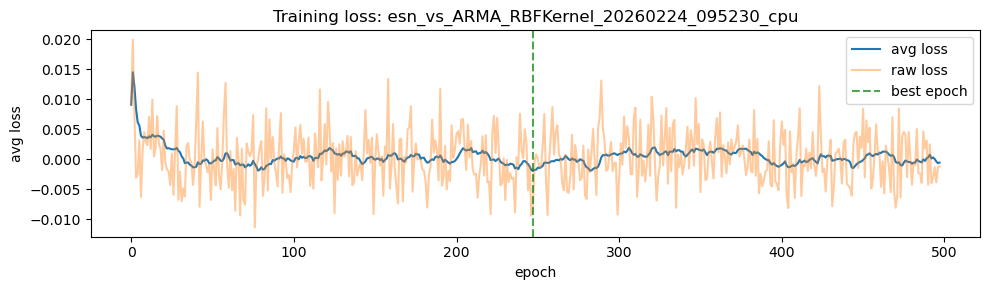

Kernel spec: RBFKernel(sigma=27.59954485390008)
Best average loss: -0.0019 at epoch 247
Final average loss: -0.0005
Final loss: -0.0012


In [58]:
results = df.iloc[row]
losses = plot_loss_from_run(results, None, overlay_raw=True, log_scale=False, overlay_lr = True, mark_best_and_drops=True)
print(f"Kernel spec: {results['kernel_spec']}")
print(f"Best average loss: {results['best_avg_loss']:.4f} at epoch {results['best_epoch']}")
print(f"Final average loss: {losses['avg_losses'][-1]:.4f}")
print(f"Final loss: {losses['losses'][-1]:.4f}")

## load and plot samples for this particular run

### ESN

In [59]:
esn_cols = [col for col in df.columns if "esn_" in col]
df.iloc[row][esn_cols]

esn_h                      500
esn_m                       20
esn_out_dim                  1
esn_activation            tanh
esn_xi_scale               1.0
esn_eta_scale             0.05
esn_target_rho            0.99
esn_xi_ma_theta    [0.5, 0.25]
Name: 1, dtype: object

In [60]:
esn = load_esn_from_df(df, row=row, which="best", map_location=device, dtype=torch.float64)
# with torch.no_grad():
#     Z = esn(T=200, N=50)
# print(Z.shape)

### Generator

In [61]:
target_cols = [col for col in df.columns if "target_" in col and "esn_" not in col]   
df.iloc[row][target_cols]

target_name                                               ARMA
target_T                                                 200.0
target_p                                                   2.0
target_q                                                   0.0
target_phi           [0.699999988079071, -0.20000000298023224]
target_theta                                                []
target_omega                                              None
target_alpha                                              None
target_beta                                               None
target_noise_spec             {'kind': 'normal', 'params': {}}
Name: 1, dtype: object

In [62]:
generator, noise = load_target_and_noise_from_df(df, row=row)
# with torch.no_grad():
#     Z_target = generator.generate(N=50, T=1000, noise=noise)
# print(Z_target.shape)

# ACF analysis

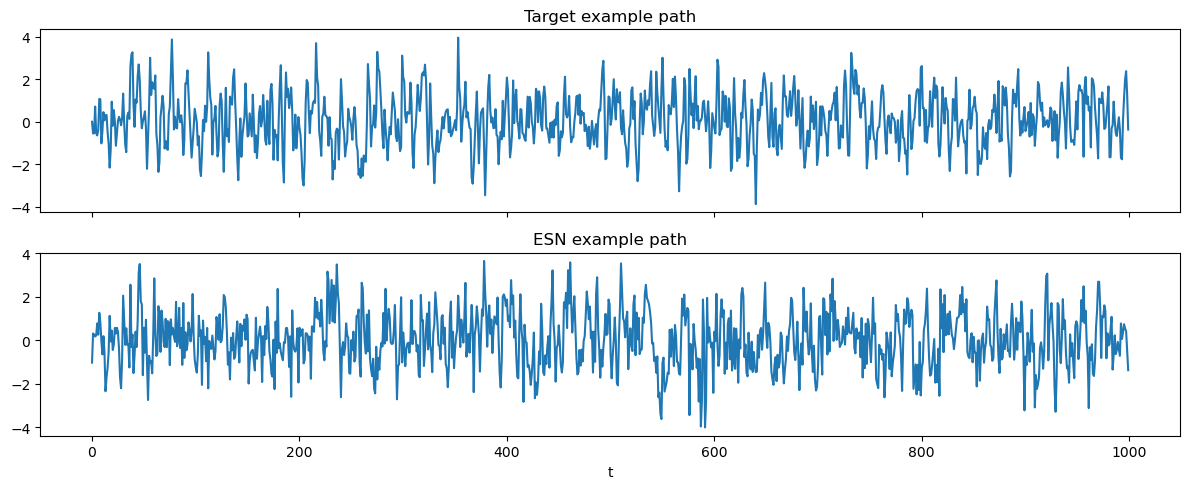

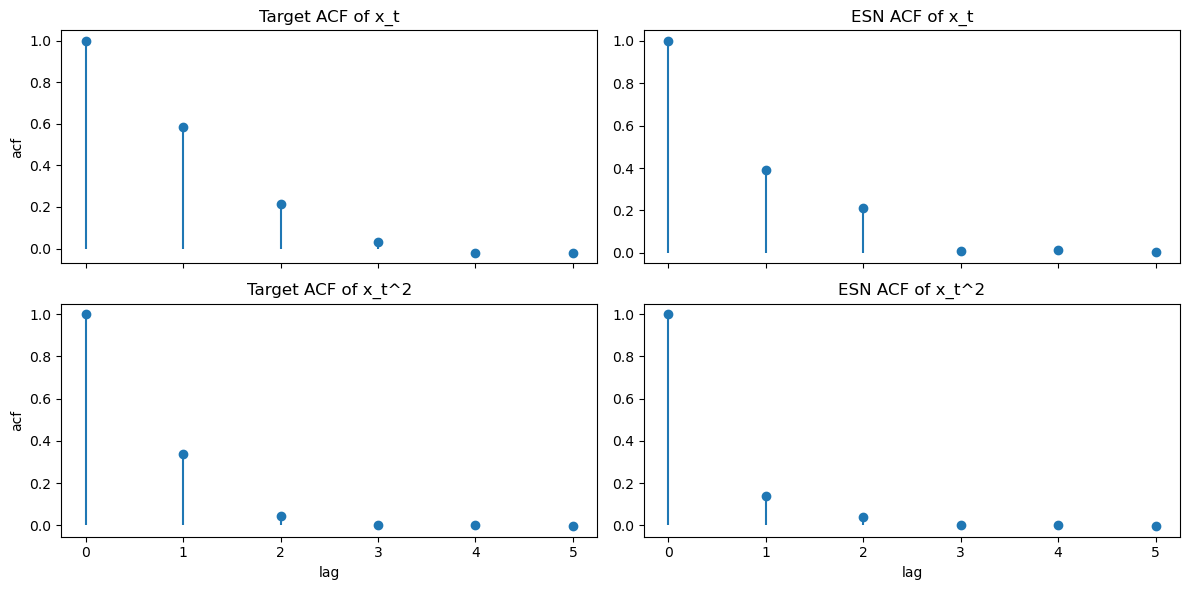

In [63]:
out = acf_compare(esn=esn, generator=generator, N=100, T=1000, lag=5, noise=noise)